In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
sys.path.insert(0, '../')
from species_classification_scripts.individual_stands_classification import Generator

### Check some distribution

In [32]:
for sp_class in ['conifer', 'decidious']:
    pix_num = 0
    for img_ind in range(1, 2): 
        imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/tmp/{}_{}.tif'.format(img_ind, sp_class)
        with rasterio.open(imgpath) as src:
            mask = src.read(1)
        pix_num += np.sum(mask)
    print(sp_class, pix_num)

conifer 64782933.0
decidious 60992630.0


In [34]:
4*64782933.0, 4*60992630.0

(259131732.0, 243970520.0)

In [29]:
imgpath

'/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/tmp/1_decidious.tif'

In [30]:
! gdalinfo $imgpath

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/tmp/1_decidious.tif
Size is 21187, 15839
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (45.522597240000003,61.577073730025148)
Pixel Size = (0.000017759611930,-0.000017759611930)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.5225972,  61.5770737) ( 45d31'21.35"E, 61d34'37.47"N)
Lower Left  (  45.5225972,  61.2957792) ( 45d31'21.35"E, 61d17'44.81"N)
Upper Right (  45.8988701,  61.5770737) ( 45d53'55.93"E, 61d34'37.47"N)
Lower Right (  45.8988701,  61.2957792) ( 45d53'55.93"E, 61d17'44.81"N)
Center      (  45.7107337,  61.4364265) 

### Set generator

In [46]:
class_0=['conifer']
class_1=['decidious']
folders = ['0', '1', '2', '3']
num_channels = 9
batch_size = 12#32

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)
generator.wv = True
generator.IMG_ROW = 1024#128
generator.IMG_COL = 1024#128
generator.sup_materials = True
generator.sup_name = '_pred.tif' #lidar
generator.sup_normalization = 40.
generator.channels_name = ['_channel_0', '_channel_1', '_channel_2', '_channel_3',
                          '_channel_4', '_channel_5', '_channel_6', '_channel_7']
weights_list = [ 1., 1.]
loss =  generator.weighted_categorical_crossentropy(weights_list)  

generator.load_dataset(folders)
generator.set_normalize_channel()

### Check generated output

In [11]:
imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1'
upper_left_x = 11902
upper_left_y = 5681
pol_width = 893
pol_height = 345

img_tmp, mask_tmp = generator.get_img_mask_array(imgpath, upper_left_x, upper_left_y, pol_width, pol_height)

/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1


Text(0.5,1,'lidar')

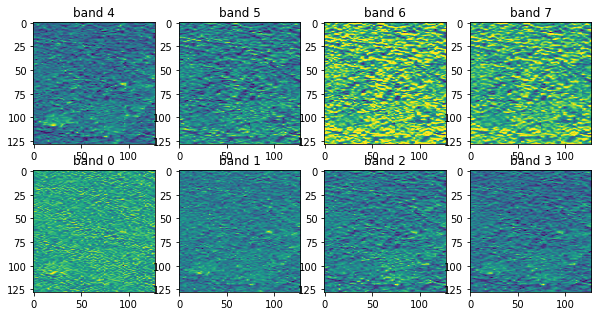

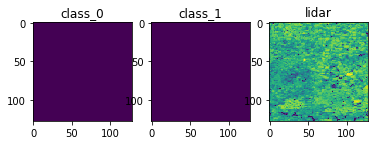

In [15]:
fig = plt.figure(figsize = (10,10))
for i in range(4):
    a = fig.add_subplot(1, 4, i+1)
    imgplot = plt.imshow(img_tmp[:,:,i])
    a.set_title('band '+str(i))

for i in range(4):
    a = fig.add_subplot(2, 4, i+1)
    imgplot = plt.imshow(img_tmp[:,:,4+i])
    a.set_title('band '+str(i+4))

fig = plt.figure(figsize = (6,6))
a = fig.add_subplot(2, 3, 1)
imgplot = plt.imshow(mask_tmp[:,:,0]>0.5)
a.set_title('class_0')
a = fig.add_subplot(2, 3, 2)
imgplot = plt.imshow(mask_tmp[:,:,1]>0.5)
a.set_title('class_1')
a = fig.add_subplot(2, 3, 3)
imgplot = plt.imshow(img_tmp[:,:,-1])
a.set_title('lidar')

In [19]:
#labels_dict = {'0': 192, '1': 368}
#class_weight, weights_list = create_class_weight(labels_dict, mu=0.8)
#weights_list

In [16]:
for img, mask in generator.train_gen():
    break

In [21]:
img.shape, mask.shape

((32, 128, 128, 9), (32, 128, 128, 2))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f3f0c23ea20>)

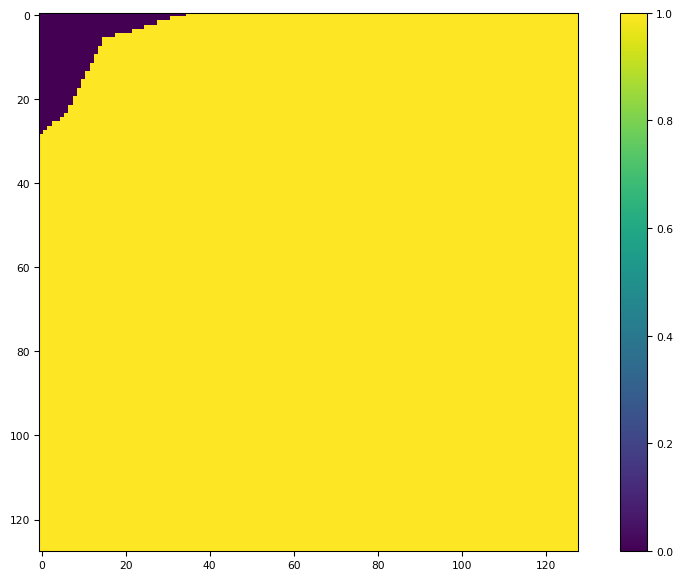

In [20]:
tiff.imshow(mask[0,:,:,1])

##  Set model

In [59]:
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [60]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.callbacks import Callback

In [61]:
model_name = 'multispectral_lidar'
save_dir = '/home/user/data/example/data/Forestry_inventory/usgs_species_classification/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [13]:
history=model.fit_generator(generator.train_gen(),epochs=20, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/20
200/200 [==============================] - 305s 2s/step - loss: 0.4730 - loss_1: 0.4730 - val_loss: 0.4706 - val_loss_1: 0.4706

Epoch 00001: val_loss improved from inf to 0.47059, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_lidar.h5

Epoch 00001: val_loss improved from inf to 0.47059, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_lidar.hdf5
Epoch 2/20
200/200 [==============================] - 291s 1s/step - loss: 0.4247 - loss_1: 0.4247 - val_loss: 0.4956 - val_loss_1: 0.4956

Epoch 00002: val_loss did not improve from 0.47059

Epoch 00002: val_loss did not improve from 0.47059
Epoch 3/20
200/200 [==============================] - 290s 1s/step - loss: 0.4002 - loss_1: 0.4002 - val_loss: 0.5109 - val_loss_1: 0.5109

Epoch 00003: val_loss did not improve from 0.47059

Epoch 00003: val_loss did not improve from 0.47059
Epoch 4/20
200/200 [=================

In [20]:
history=model.fit_generator(generator.train_gen(),epochs=2, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/2
200/200 [==============================] - 300s 1s/step - loss: 0.3229 - loss_1: 0.3229 - val_loss: 0.3341 - val_loss_1: 0.3341

Epoch 00001: val_loss did not improve from 0.32141

Epoch 00001: val_loss did not improve from 0.32141
Epoch 2/2
200/200 [==============================] - 290s 1s/step - loss: 0.3210 - loss_1: 0.3210 - val_loss: 0.3477 - val_loss_1: 0.3477

Epoch 00002: val_loss did not improve from 0.32141

Epoch 00002: val_loss did not improve from 0.32141


In [15]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [14]:
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_lidar.json'

In [62]:
model_name = 'multispectral_lidar'
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [50]:
model_name = 'multispectral_inventory'
model.load_weights(save_dir+"{}.h5".format(model_name)) 

### Check intersection between train and val samples

In [50]:
samples_val = []
for key in generator.json_file_linden_val.keys():
    sample = generator.json_file_linden_val[key]
    samples_val.append([key.split('_')[0], sample['upper_left_x'], sample['upper_left_y'], sample['pol_width'], sample['pol_height']])
    
samples_train = []
for key in generator.json_file_linden_train.keys():
    sample = generator.json_file_linden_train[key]
    samples_train.append([key.split('_')[0], sample['upper_left_x'], sample['upper_left_y'], sample['pol_width'], sample['pol_height']])

In [51]:
len(set(tuple(i) for i in samples_val+samples_train)) 

1368

In [52]:
k = 0
for sample in samples_val:
    if sample in samples_train:
        k += 1
k

0

## write geojson for validation

In [41]:
import tifffile as tiff
import numpy as np
import rasterio
import matplotlib
import matplotlib.pyplot as plt

import geojson
from rasterio.mask import mask
from osgeo import gdal, osr
from rasterio.plot import plotting_extent

from rasterio import features
from shapely import geometry
from shapely.geometry import Polygon, MultiPolygon

import pandas as pd
import json
import re
import subprocess
from os import listdir
from pyproj import Proj, transform

import scipy
import cv2
from glob import glob

In [46]:
for item in generator.json_file_linden_val.items():
    print(item)

('1_55', {'upper_left_x': 12206, 'upper_left_y': 6323, 'pol_width': 156, 'pol_height': 102, 'pix_area': 3.175735347500058e-06})
('1_186', {'upper_left_x': 11960, 'upper_left_y': 6590, 'pol_width': 367, 'pol_height': 115, 'pix_area': 7.364271821955394e-06})
('0_149', {'upper_left_x': 1940, 'upper_left_y': 13632, 'pol_width': 346, 'pol_height': 137, 'pix_area': 8.528339834300876e-06})
('1_466', {'upper_left_x': 10831, 'upper_left_y': 12749, 'pol_width': 122, 'pol_height': 128, 'pix_area': 2.1385080191163577e-06})
('1_106', {'upper_left_x': 16891, 'upper_left_y': 7355, 'pol_width': 428, 'pol_height': 220, 'pix_area': 1.1587165591625789e-05})
('1_300', {'upper_left_x': 10515, 'upper_left_y': 6583, 'pol_width': 1141, 'pol_height': 175, 'pix_area': 2.80921912057745e-06})
('1_213', {'upper_left_x': 9987, 'upper_left_y': 8202, 'pol_width': 163, 'pol_height': 38, 'pix_area': 1.2146296179161857e-06})
('1_1078', {'upper_left_x': 262, 'upper_left_y': 6579, 'pol_width': 467, 'pol_height': 323, 'pix

In [43]:
item[1]

{'upper_left_x': 1565,
 'upper_left_y': 2491,
 'pol_width': 190,
 'pol_height': 248,
 'pix_area': 9.251986169194786e-06}

In [ ]:
upper_left_x + pol_width, upper_left_y - pol_height

In [218]:
from shapely.geometry import box
print(box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height))

POLYGON ((2570 904, 2570 889, 2556 889, 2556 904, 2570 904))


In [234]:
from shapely.geometry import Polygon, mapping
mapping(sh_polygon)

In [244]:
from shapely.geometry import Polygon, mapping

extention_list = []
for item in generator.json_file_linden_val.items():
    geom = box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height)
    geom = mapping(geom)['coordinates']
    extention_list.append({'geometry':{'type': 'Polygon', 
                                                'coordinates':geom}})

crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:32639"
        }
    }      
feature_collection = geojson.FeatureCollection(extention_list, crs=crs)
geojson_file = 'validation_linden.geojson'.format(folder, folder)
with open(geojson_file, 'w') as f:
    geojson.dump(feature_collection, f)

In [245]:
feature_collection

{"crs": {"properties": {"name": "EPSG:32639"}, "type": "name"}, "features": [{"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0

In [243]:
extention_list = []
for item in generator.json_file_oak_val.items():
    geom = box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height)
    geom = mapping(geom)['coordinates']
    extention_list.append(geom)

crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:32639"
        }
    }      
feature_collection = geojson.FeatureCollection(extention_list, crs=crs)
geojson_file = 'validation_oak.geojson'.format(folder, folder)
with open(geojson_file, 'w') as f:
    geojson.dump(feature_collection, f)

## All val predict

In [81]:
generator.json_file_linden_val

{'1_55': {'upper_left_x': 12206,
  'upper_left_y': 6323,
  'pol_width': 156,
  'pol_height': 102,
  'pix_area': 3.175735347500058e-06},
 '1_186': {'upper_left_x': 11960,
  'upper_left_y': 6590,
  'pol_width': 367,
  'pol_height': 115,
  'pix_area': 7.364271821955394e-06},
 '0_149': {'upper_left_x': 1940,
  'upper_left_y': 13632,
  'pol_width': 346,
  'pol_height': 137,
  'pix_area': 8.528339834300876e-06},
 '1_466': {'upper_left_x': 10831,
  'upper_left_y': 12749,
  'pol_width': 122,
  'pol_height': 128,
  'pix_area': 2.1385080191163577e-06},
 '1_106': {'upper_left_x': 16891,
  'upper_left_y': 7355,
  'pol_width': 428,
  'pol_height': 220,
  'pix_area': 1.1587165591625789e-05},
 '1_300': {'upper_left_x': 10515,
  'upper_left_y': 6583,
  'pol_width': 1141,
  'pol_height': 175,
  'pix_area': 2.80921912057745e-06},
 '1_213': {'upper_left_x': 9987,
  'upper_left_y': 8202,
  'pol_width': 163,
  'pol_height': 38,
  'pix_area': 1.2146296179161857e-06},
 '1_1078': {'upper_left_x': 262,
  'uppe

In [102]:
def pred_val(cl_json):
    imgarr=[]
    maskarr=[]
    for key in cl_json.keys():
        imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/'\
            +key.split('_')[0]
        upper_left_x, upper_left_y, pol_width, pol_height = cl_json[key]['upper_left_x'], cl_json[key]['upper_left_y'],\
                                                            cl_json[key]['pol_width'], cl_json[key]['pol_height']
        img, mask = generator.get_img_mask_array(imgpath, upper_left_x, upper_left_y, pol_width, pol_height)
        imgarr.append(img)
        maskarr.append(mask)

    imgarr = np.asarray(imgarr)
    maskarr = np.asarray(maskarr)
    return imgarr, maskarr

img_linden, mask_linden = pred_val(generator.json_file_linden_val)
img_oak, mask_oak = pred_val(generator.json_file_oak_val)
pred_linden = model.predict(img_linden)
pred_oak = model.predict(img_oak)

In [59]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [79]:
json_file = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/tmp/0_decidious.json'
with open(json_file, 'r') as f:
                js_tmp = json.load(f)
keys_list = set(js_tmp.keys())

In [80]:
len(keys_list)

271

In [104]:
# full json
def pred_val(cl_json):
    imgarr=[]
    maskarr=[]
    for key in cl_json.keys():
        imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/'\
            +key.split('_')[0]
        upper_left_x, upper_left_y, pol_width, pol_height = cl_json[key]['upper_left_x'], cl_json[key]['upper_left_y'],\
                                                            cl_json[key]['pol_width'], cl_json[key]['pol_height']
        img, mask = generator.get_img_mask_array(imgpath, upper_left_x, upper_left_y, pol_width, pol_height)
        imgarr.append(img)
        maskarr.append(mask)

    imgarr = np.asarray(imgarr)
    maskarr = np.asarray(maskarr)
    return imgarr, maskarr

img_linden, mask_linden = pred_val(merge_two_dicts(generator.json_file_linden_val, generator.json_file_linden_train))
img_oak, mask_oak = pred_val(merge_two_dicts(generator.json_file_oak_val, generator.json_file_oak_train))
pred_linden = model.predict(img_linden)
pred_oak = model.predict(img_oak)

In [83]:
print(len(generator.json_file_linden_train.keys()), len(generator.json_file_oak_train.keys()))
print(len(generator.json_file_linden_val.keys()), len(generator.json_file_oak_val.keys()))

756 1219
341 534


In [86]:
len(generator.json_file_linden_train.keys())

1899

In [69]:
pred_linden.shape, pred_oak.shape, mask_oak.shape

((424, 128, 128, 2), (612, 128, 128, 2), (612, 128, 128, 2))

In [44]:
pred_linden.shape, pred_oak.shape, mask_oak.shape

((799, 64, 64, 2), (665, 64, 64, 2), (665, 64, 64, 2))

Text(0.5,1,'mask')

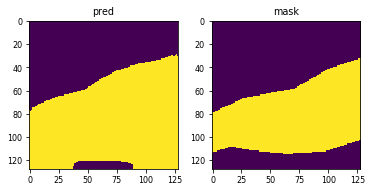

In [37]:
ind = 78
fig = plt.figure(figsize = (6,6))
a = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow((pred_oak[ind,:,:,0]>0.5)*np.sum(mask_oak[ind],axis=-1))
a.set_title('pred')
a = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(mask_oak[ind,:,:,0])
a.set_title('mask')

In [49]:
correct_samples = 0
wrong_samples = 0
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1
        
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1

print(correct_samples / (correct_samples + wrong_samples))

0.9316939890710383


In [82]:
correct_samples = 0
wrong_samples = 0
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1
        
print(correct_samples / (correct_samples + wrong_samples))

0.9669172932330827


In [83]:
correct_samples = 0
wrong_samples = 0
        
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1

print(correct_samples / (correct_samples + wrong_samples))

0.9023779724655819


In [61]:
TP = 0
FP = 0
TN = 0
FN = 0
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        TP += 1
    else:
        FN += 1
        
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        TN += 1
    else:
        FP += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN) 
f1_cl = 2*((precision*recall)/(precision+recall))

f1_cl, accuracy

(0.8603351955307261, 0.8789346246973365)

In [62]:
TP = 0
FP = 0
TN = 0
FN = 0
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        TN += 1
    else:
        FP += 1
        
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        TP += 1
    else:
        FN += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN) 
f1_cl = 2*((precision*recall)/(precision+recall))

f1_cl, accuracy

(0.8931623931623932, 0.8789346246973365)

## F1

In [105]:
TP = 0
FP = 0
TN = 0
FN = 0
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        TP += 1
    else:
        FN += 1
        
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        TN += 1
    else:
        FP += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN) 
f1_cl = 2*((precision*recall)/(precision+recall))

f1_cl, accuracy

(0.8412698412698414, 0.8547215496368039)

In [106]:
TP = 0
FP = 0
TN = 0
FN = 0
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        TN += 1
    else:
        FP += 1
        
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        TP += 1
    else:
        FN += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN) 
f1_cl = 2*((precision*recall)/(precision+recall))

f1_cl, accuracy

(0.8660714285714286, 0.8547215496368039)

In [42]:
(86+90)/2

88.0

In [41]:
(0.875140607424072+0.9061707523245984)/2

0.8906556798743352

In [42]:
(0.8955223880597014+0.9242298084929226)/2

0.909876098276312

In [43]:
(0.861431870669746+0.900497512437811)/2

0.8809646915537785

***
***

# Evaluation

In [77]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

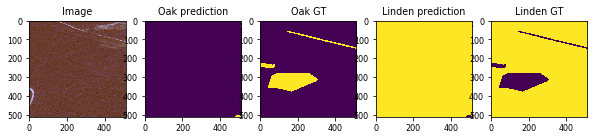

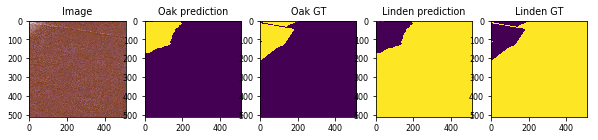

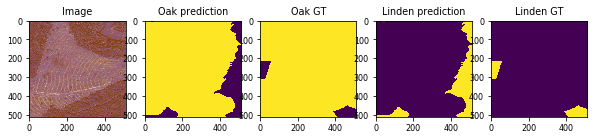

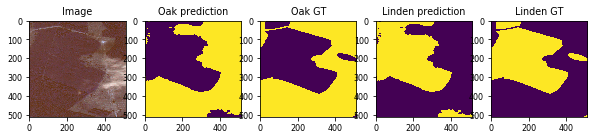

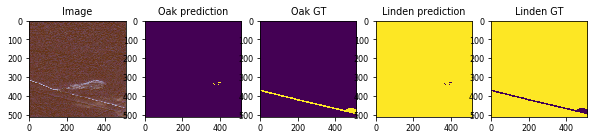

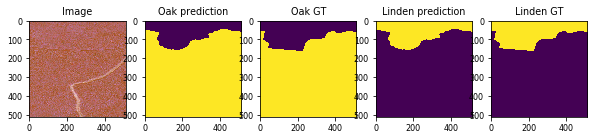

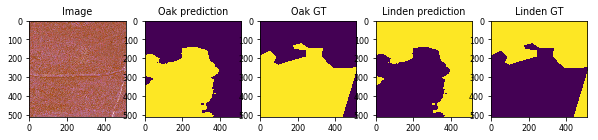

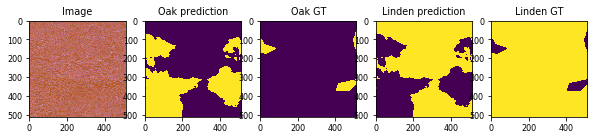

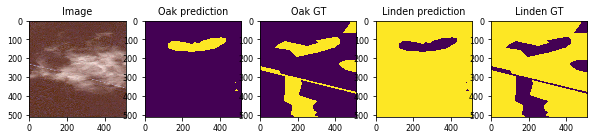

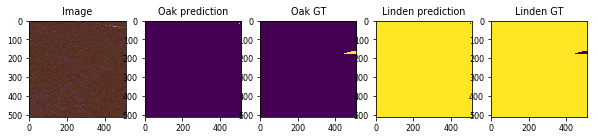

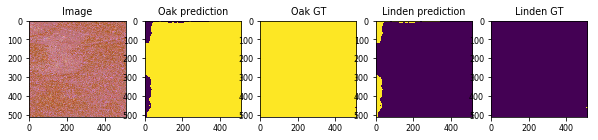

In [78]:
for num in range(1, 12):
    fig = plt.figure(figsize=(10, 10))
    a = fig.add_subplot(1, 5, 1)
    a.set_title('Image')
    imgplot = plt.imshow((img[num, :, :, 0:3] - np.min(img[num, :, :, 0:3]))/(np.max(img[num, :, :, 0:3]) 
                                                                           - np.min(img[num, :, :, 0:3])) )
    a = fig.add_subplot(1, 5, 2)
    a.set_title('Oak prediction')
    imgplot = plt.imshow(np.where(np.argmax(pred[num,:,:,:], axis=2)==0, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 3)
    a.set_title('Oak GT')
    imgplot = plt.imshow(mask[num,:,:,0])
    a = fig.add_subplot(1, 5, 4)
    a.set_title('Linden prediction')
    imgplot = plt.imshow(np.where(np.argmax(pred[num,:,:,:], axis=2)==1, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 5)
    a.set_title('Linden GT')
    imgplot = plt.imshow(mask[num,:,:,1])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2aeb220d30>)

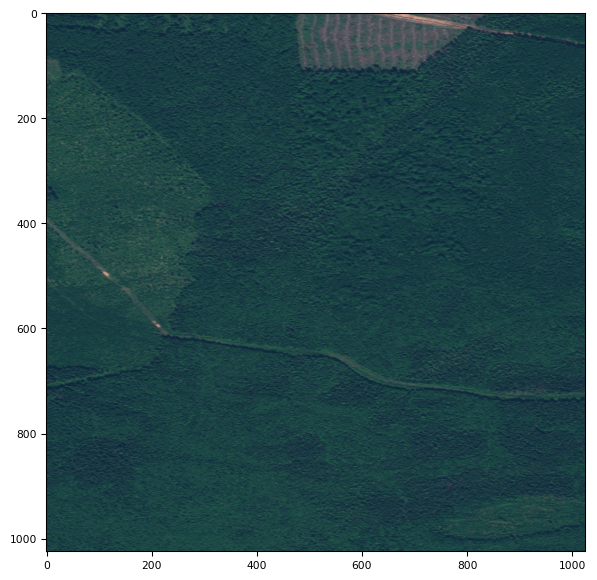

In [30]:
num = 1
rgb = np.asarray([img[num, :, :, 4], img[num, :, :, 2], img[num, :, :, 1]])
tiff.imshow((rgb-np.min(rgb))/(np.max(rgb)-np.min(rgb)))

In [51]:
channel_name = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/2_channel_0.tif'
with rasterio.open(channel_name) as src:
    size_x = src.width
    size_y = src.height
#print(upper_left_x, upper_left_y, pol_width, pol_height)
print(size_x, size_y)

2107 1272


In [52]:
img_lidar, mask = generator.get_img_mask_array(imgpath='/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/2', 
                             pol_height=1024, pol_width=1024, 
                             upper_left_x=0, upper_left_y=0)

In [73]:
num_channels = 9

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)

generator.wv = True
generator.IMG_ROW = 512#128
generator.IMG_COL = 512#128
generator.sup_normalization = 40.
generator.channels_name = ['_channel_0', '_channel_1', '_channel_2', '_channel_3',
                          '_channel_4', '_channel_5', '_channel_6', '_channel_7']
weights_list = [ 1., 1.]

generator.sup_materials = True
generator.sup_name = '_pred.tif' #lidar
generator.sup_normalization = 40.

generator.load_dataset(folders)
generator.set_normalize_channel()

img_lidar, mask = generator.get_img_mask_array(imgpath='/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1', 
                             pol_height=1024, pol_width=1024, 
                             upper_left_x=0, upper_left_y=0)

pred = model.predict(np.asarray([img_lidar]))

In [ ]:
num_channels = 9

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)

generator.sup_materials = True
generator.sup_name = '_pred.tif' #lidar
generator.sup_normalization = 40.

generator.load_dataset(folders)
generator.set_normalize_channel()

img_height, mask = generator.get_img_mask_array(imgpath='/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1', 
                             pol_height=size_x, pol_width=size_y, 
                             upper_left_x=0, upper_left_y=0)

In [ ]:
num_channels = 9

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)

generator.sup_materials = True
generator.sup_name = '_pred.tif' #lidar
generator.sup_normalization = 40.

generator.load_dataset(folders)
generator.set_normalize_channel()

img_age, mask = generator.get_img_mask_array(imgpath='/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1', 
                             pol_height=size_x, pol_width=size_y, 
                             upper_left_x=0, upper_left_y=0)

In [ ]:
num_channels = 9

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)

generator.sup_materials = True
generator.sup_name = '_pred.tif' #lidar
generator.sup_normalization = 40.

generator.load_dataset(folders)
generator.set_normalize_channel()

img_pred, mask = generator.get_img_mask_array(imgpath='/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1', 
                             pol_height=size_x, pol_width=size_y, 
                             upper_left_x=0, upper_left_y=0)

In [ ]:
num_channels = 9

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)

generator.sup_materials = True
generator.sup_name = '_pred.tif' #lidar
generator.sup_normalization = 40.

generator.load_dataset(folders)
generator.set_normalize_channel()

img_multi, mask = generator.get_img_mask_array(imgpath='/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1', 
                             pol_height=size_x, pol_width=size_y, 
                             upper_left_x=0, upper_left_y=0)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f2b208d0668>)

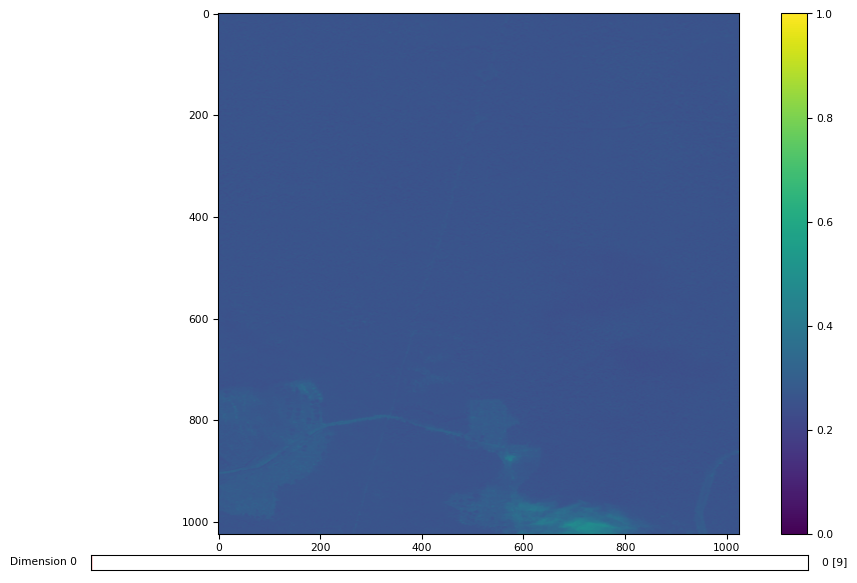

In [55]:
tiff.imshow(img_lidar)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f2d9c744ba8>)

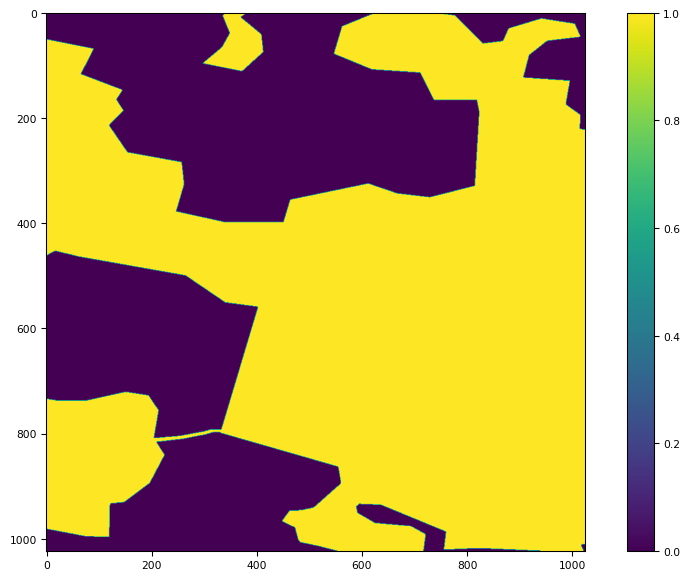

In [56]:
tiff.imshow(mask[:,:,0])

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f2ac7f1b2b0>)

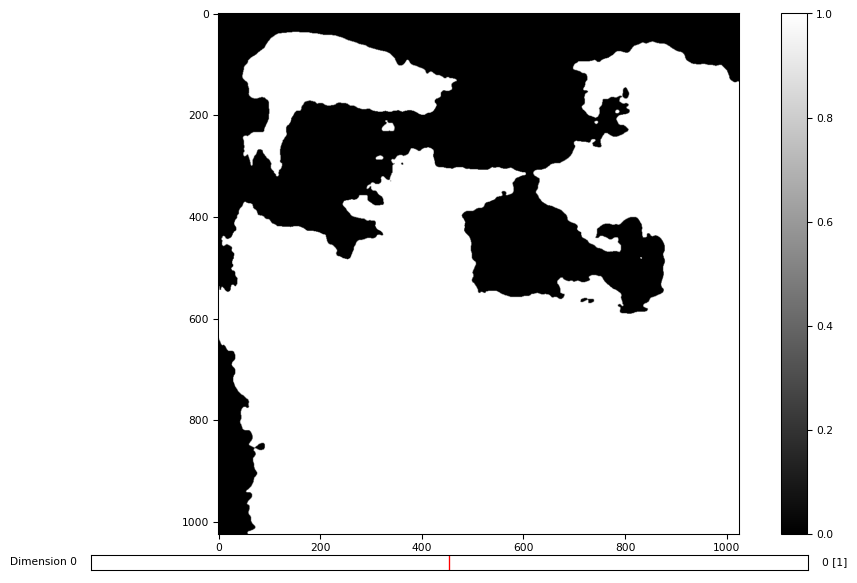

In [67]:
tiff.imshow(pred[0, :,:,0]>0.5)

In [71]:
tmp = tiff.imread('/home/user/data/krasnoborsk/arctic_dem.tif')

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f2ac7c837f0>)

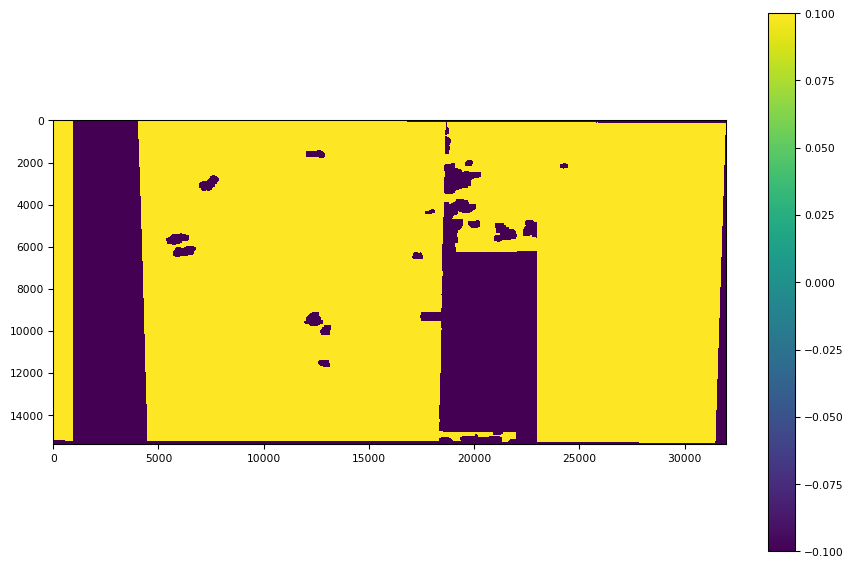

In [72]:
tiff.imshow(tmp)